# Demonstrative workflow for the automated downloading and identification to species level of geolocated Flickr images

In this notebook, we show the minimal workflow for the automated fetching and to species-level identification of geolocated Flickr images. Images are fetched through the Flickr API based on fuzzy keyword matches with any tags (title, description, keywords), after which the image urls are used to download images locally and files are sent for species-level classification by machine vision models through their respective API's (e.g., pl@ntnet), which responds with an identification rank and associated probability of exact species match. No manual verification of the final classified images is performed afterwards, but the script checks if the queried species keyword in the Flickr API corresponds with the first rank of the machine vision model API response, to only retain images that have a very high likelihood for being the species of interest, thus reflecting 'true' occurrences. 

Note that these scripts will not work if the platform's respective API keys (Flickr and pl@ntnet in this example) have not been set in your local .env file located in the root directory of the library. Demo keys for these APIs can be obtained freely through the developer section of both platforms. The .env file can be opened in any text editor and should look something like this:
  
FLICKR_API_KEY='*insert flickr API key*'  
FLICKR_API_SECRET='*insert flickr secret*'  
PLANTNET_API_KEY='*insert pl@ntnet API key*'

Within the context of compliance to existing GDPR regulation, publishing these observations as well as their associated identifiers and coordinates should not be done publicly without informing the original poster of the images on Flickr and asking for their permission explicitly.

Please contact me with persistent issues at **simon.reynaert@plantentuinmeise.be**.

## 1. Setting up your local environment and testing dependencies

In [1]:
#set the paths correctly on local device so that functions can be imported
import sys
import os

notebook_dir = os.getcwd()
print(f"The notebook is located at '{notebook_dir}'.")
src_path = os.path.abspath(os.path.join(notebook_dir, "../src"))
print(f"The functions are located at '{src_path}'.")

# Add to Python path if not already there
if src_path not in sys.path:
    sys.path.insert(0, src_path)

The notebook is located at 'c:\Users\simon\Documents\GitHub\iEcology-IAS-miner\scripts'.
The functions are located at 'c:\Users\simon\Documents\GitHub\iEcology-IAS-miner\src'.


In [2]:
#set up the project path (i.e. root folder of the repository) for module imports
import sys
import os

notebook_dir = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_dir, ".."))

# Only add if not present, which avoids duplicates on reruns
if project_path not in sys.path:
    sys.path.insert(0, project_path)

print(f"Project path now includes: {project_path}")

Project path now includes: c:\Users\simon\Documents\GitHub\iEcology-IAS-miner


In [4]:
#test all imports

from activity_mining.get_flickr_mentions_final import (
    get_flickr_client, 
    load_species_list, 
    scrape_flickr_data,
    EU_BOUNDING_BOXES #predefined bounding box for Europe
)
from data_processing.process_flickr_images import process_flickr_data
from flickr_to_plantnet.DL_flickr_images import FlickrImageDownloader, download_species_images
from flickr_to_plantnet.plantnet_identification import run_full_pipeline
from flickr_to_plantnet.generate_observation_map import generate_observation_map

print("All imports were successful.")

All imports were successful.


## 2. Fetching the Flickr images, geolocating them and deduplicating repeat observations

### 2.1. Query Flickr for images matching species names and save metadata

In [6]:
from activity_mining.get_flickr_mentions_final import (
    get_flickr_client, 
    scrape_flickr_data,
    EU_BOUNDING_BOXES #predefined bounding box for Europe
)

#load client
flickr = get_flickr_client()

#load sp list
species_list = ["Reynoutria japonica"] #this list, used for querying images associated with keywords of species names on flickr can be adapated to your needs (e.g., other IAS species, synonyms, etc.)

#fetch flickr data
results_df = scrape_flickr_data(
    flickr_client = flickr,
    species_list = species_list,
    bounding_boxes= EU_BOUNDING_BOXES,
    start_date = "2004-01-01",
    end_date = "2025-12-31")

#save results df
results_df.to_csv("Reynoutria_japonica_example_Flickr.csv", index=False)

#show head of results
results_df.head()

📅 Scraping data between 2004-01-01 and 2025-12-31...


Fetching for EU:   0%|          | 0/1 [00:00<?, ?it/s]

Loading formatted geocoded file...


Fetching for EU: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


,photo_id,scientific_name,country,date_taken,latitude,longitude,url,tags
0,54909908330,Reynoutria japonica,NL,2025-11-08 11:50:48,52.302766,5.000035,None,fallopiajaponica reynoutriajaponica polygonumc...
1,54845527262,Reynoutria japonica,PL,2025-09-19 05:11:29,51.076337,17.027542,https://live.staticflickr.com/65535/5484552726...,japaneseknotweed asianknotweed rdestowiecostro...
2,54190445341,Reynoutria japonica,PL,2024-10-11 16:59:31,51.076337,17.027542,https://live.staticflickr.com/65535/5419044534...,japaneseknotweed asianknotweed rdestowiecostro...
3,54173787691,Reynoutria japonica,PL,2024-09-21 15:31:58,51.076337,17.027542,https://live.staticflickr.com/65535/5417378769...,japaneseknotweed asianknotweed rdestowiecostro...
4,54002984902,Reynoutria japonica,GB,2024-08-31 15:15:52,52.075677,-4.161374,https://live.staticflickr.com/65535/5400298490...,garden plant perennial fallopiajaponica japane...


### 2.2. Deduplicate and geocode images with missing country tags

In [7]:
# !!only works if the mined data .csv is located in the same folder as this notebook!!
from data_processing.process_flickr_images import process_flickr_data

process_flickr_data("Reynoutria_japonica_example_Flickr.csv",#input csv file with mined flickr data 
                    "deduplicated_geolocated_Reynoutria_japonica_example.csv", #output csv file with processed data
                    100) #the 100 here is the distance in meters between observations made by the same person on the same day for deduplication

Deduplicating rows:   0%|          | 0/41 [00:00<?, ?it/s]

Deduplicating rows: 100%|██████████| 41/41 [00:00<00:00, 3689.48it/s]

Deduplicated & geocoded European data saved to: deduplicated_geolocated_Reynoutria_japonica_example.csv
Number of rows in final CSV: 27


### 2.3. Download geolocated and filtered images locally using metadata URL's

In [8]:
from flickr_to_plantnet.DL_flickr_images import FlickrImageDownloader, download_species_images

# Your custom configuration
results = download_species_images(
    csv_path='deduplicated_geolocated_Reynoutria_japonica_example.csv',
    species_list=['Reynoutria japonica'], #adapt list based on species of interest present in the originally mined .csv
    skip_processed=True,
    processed_csv_path='downloaded_images_Reynoutria_japonica_example.csv' #tracks how many are downloaded and processed and keeps their metadata
)


**Starting processing for species: Reynoutria japonica**
Processing 25 observations for Reynoutria japonica...
  ✅ Saved image and metadata for ID: 42364521564
   💤 Pausing for 0.99 seconds...
  ✅ Saved image and metadata for ID: 42364521064
   💤 Pausing for 1.42 seconds...
  ✅ Saved image and metadata for ID: 49992671526
   💤 Pausing for 0.57 seconds...
  ✅ Saved image and metadata for ID: 42227719200
   💤 Pausing for 0.62 seconds...
  ✅ Saved image and metadata for ID: 50182511527
   💤 Pausing for 1.31 seconds...
  ✅ Saved image and metadata for ID: 51444019700
   💤 Pausing for 1.86 seconds...
  ✅ Saved image and metadata for ID: 50023375437
   💤 Pausing for 0.70 seconds...
  ✅ Saved image and metadata for ID: 51833590842
   💤 Pausing for 0.74 seconds...
  ✅ Saved image and metadata for ID: 51863869930
   💤 Pausing for 1.72 seconds...
  ✅ Saved image and metadata for ID: 51895385250
   💤 Pausing for 1.69 seconds...
  ✅ Saved image and metadata for ID: 50781450247
   💤 Pausing for 1.

## 3. Send images to pl@ntnet API for identification (free tier limited to 500 images per day)

In [9]:
import pandas as pd
from flickr_to_plantnet.plantnet_identification import run_full_pipeline

summary, high_fidelity = run_full_pipeline(
    base_dir="PlantNet_Batch_Images",
    metadata_file="PlantNet_Batch_Images/master_observations_metadata.csv",
    output_summary_file="full_API_response_analysis.csv",
    output_high_fidelity_file="full_API_validated_plants.csv"
)

#make df
df = pd.read_csv(high_fidelity)

#print head of final observations df
df.head()


📋 Loading metadata to get expected species...
✅ Loaded metadata for 21 observations
✅ Found 26 observation folders

--- Processing ID 1/26: 42227719200 ---
  🎯 Expected species: Reynoutria japonica
  📊 Got 10 total results
    1. Reynoutria japonica (Score: 0.0988)
    2. Reynoutria sachalinensis (Score: 0.0702)
    3. Glycine max (Score: 0.0175)
    4. Ipomoea batatas (Score: 0.0094)
    5. Fagopyrum esculentum (Score: 0.0071)
    ✅ MATCH! Expected species found at rank 1

--- Processing ID 2/26: 42364521064 ---
  🎯 Expected species: Reynoutria japonica
  📊 Got 10 total results
    1. Reynoutria japonica (Score: 0.3896)
    2. Reynoutria sachalinensis (Score: 0.0295)
    3. Anredera cordifolia (Score: 0.0068)
    4. Castanea seguinii (Score: 0.0067)
    5. Clethra barbinervis (Score: 0.0032)
    ✅ MATCH! Expected species found at rank 1

--- Processing ID 3/26: 42364521564 ---
  🎯 Expected species: Reynoutria japonica
  📊 Got 4 total results
    1. Reynoutria japonica (Score: 0.5888)


,photo_id,scientific_name,latitude,longitude,local_folder,local_path,PlantNet_Confidence_Score,API_Status
0,42364521564,Reynoutria japonica,43.309202,-1.959753,42364521564,PlantNet_Batch_Images\42364521564\42364521564.jpg,0.58877,Success
1,42364521064,Reynoutria japonica,43.307038,-1.966289,42364521064,PlantNet_Batch_Images\42364521064\42364521064.jpg,0.38959,Success
2,49992671526,Reynoutria japonica,47.707985,19.231352,49992671526,PlantNet_Batch_Images\49992671526\49992671526.jpg,0.31842,Success
3,42227719200,Reynoutria japonica,48.461936,7.929847,42227719200,PlantNet_Batch_Images\42227719200\42227719200.jpg,0.09876,Success
4,50182511527,Reynoutria japonica,51.563785,5.032682,50182511527,PlantNet_Batch_Images\50182511527\50182511527.jpg,0.73669,Success


## 4. Plot verified observations on EU map

📊 Loading data from: full_API_validated_plants.csv
✅ Loaded 13 observations with valid coordinates.
🗺️ Generating map visualization...
🔍 Auto-set map extent to: Lon -5.16-20.23, Lat 42.31-59.38


c:\Users\simon\Documents\GitHub\iEcology-IAS-miner\.venv\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\simon\Documents\GitHub\iEcology-IAS-miner\.venv\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\simon\Documents\GitHub\iEcology-IAS-miner\.venv\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


✅ Map saved to: Reynoutria_japonica_EU_Map.png

Map generation complete. View the file: Reynoutria_japonica_EU_Map.png


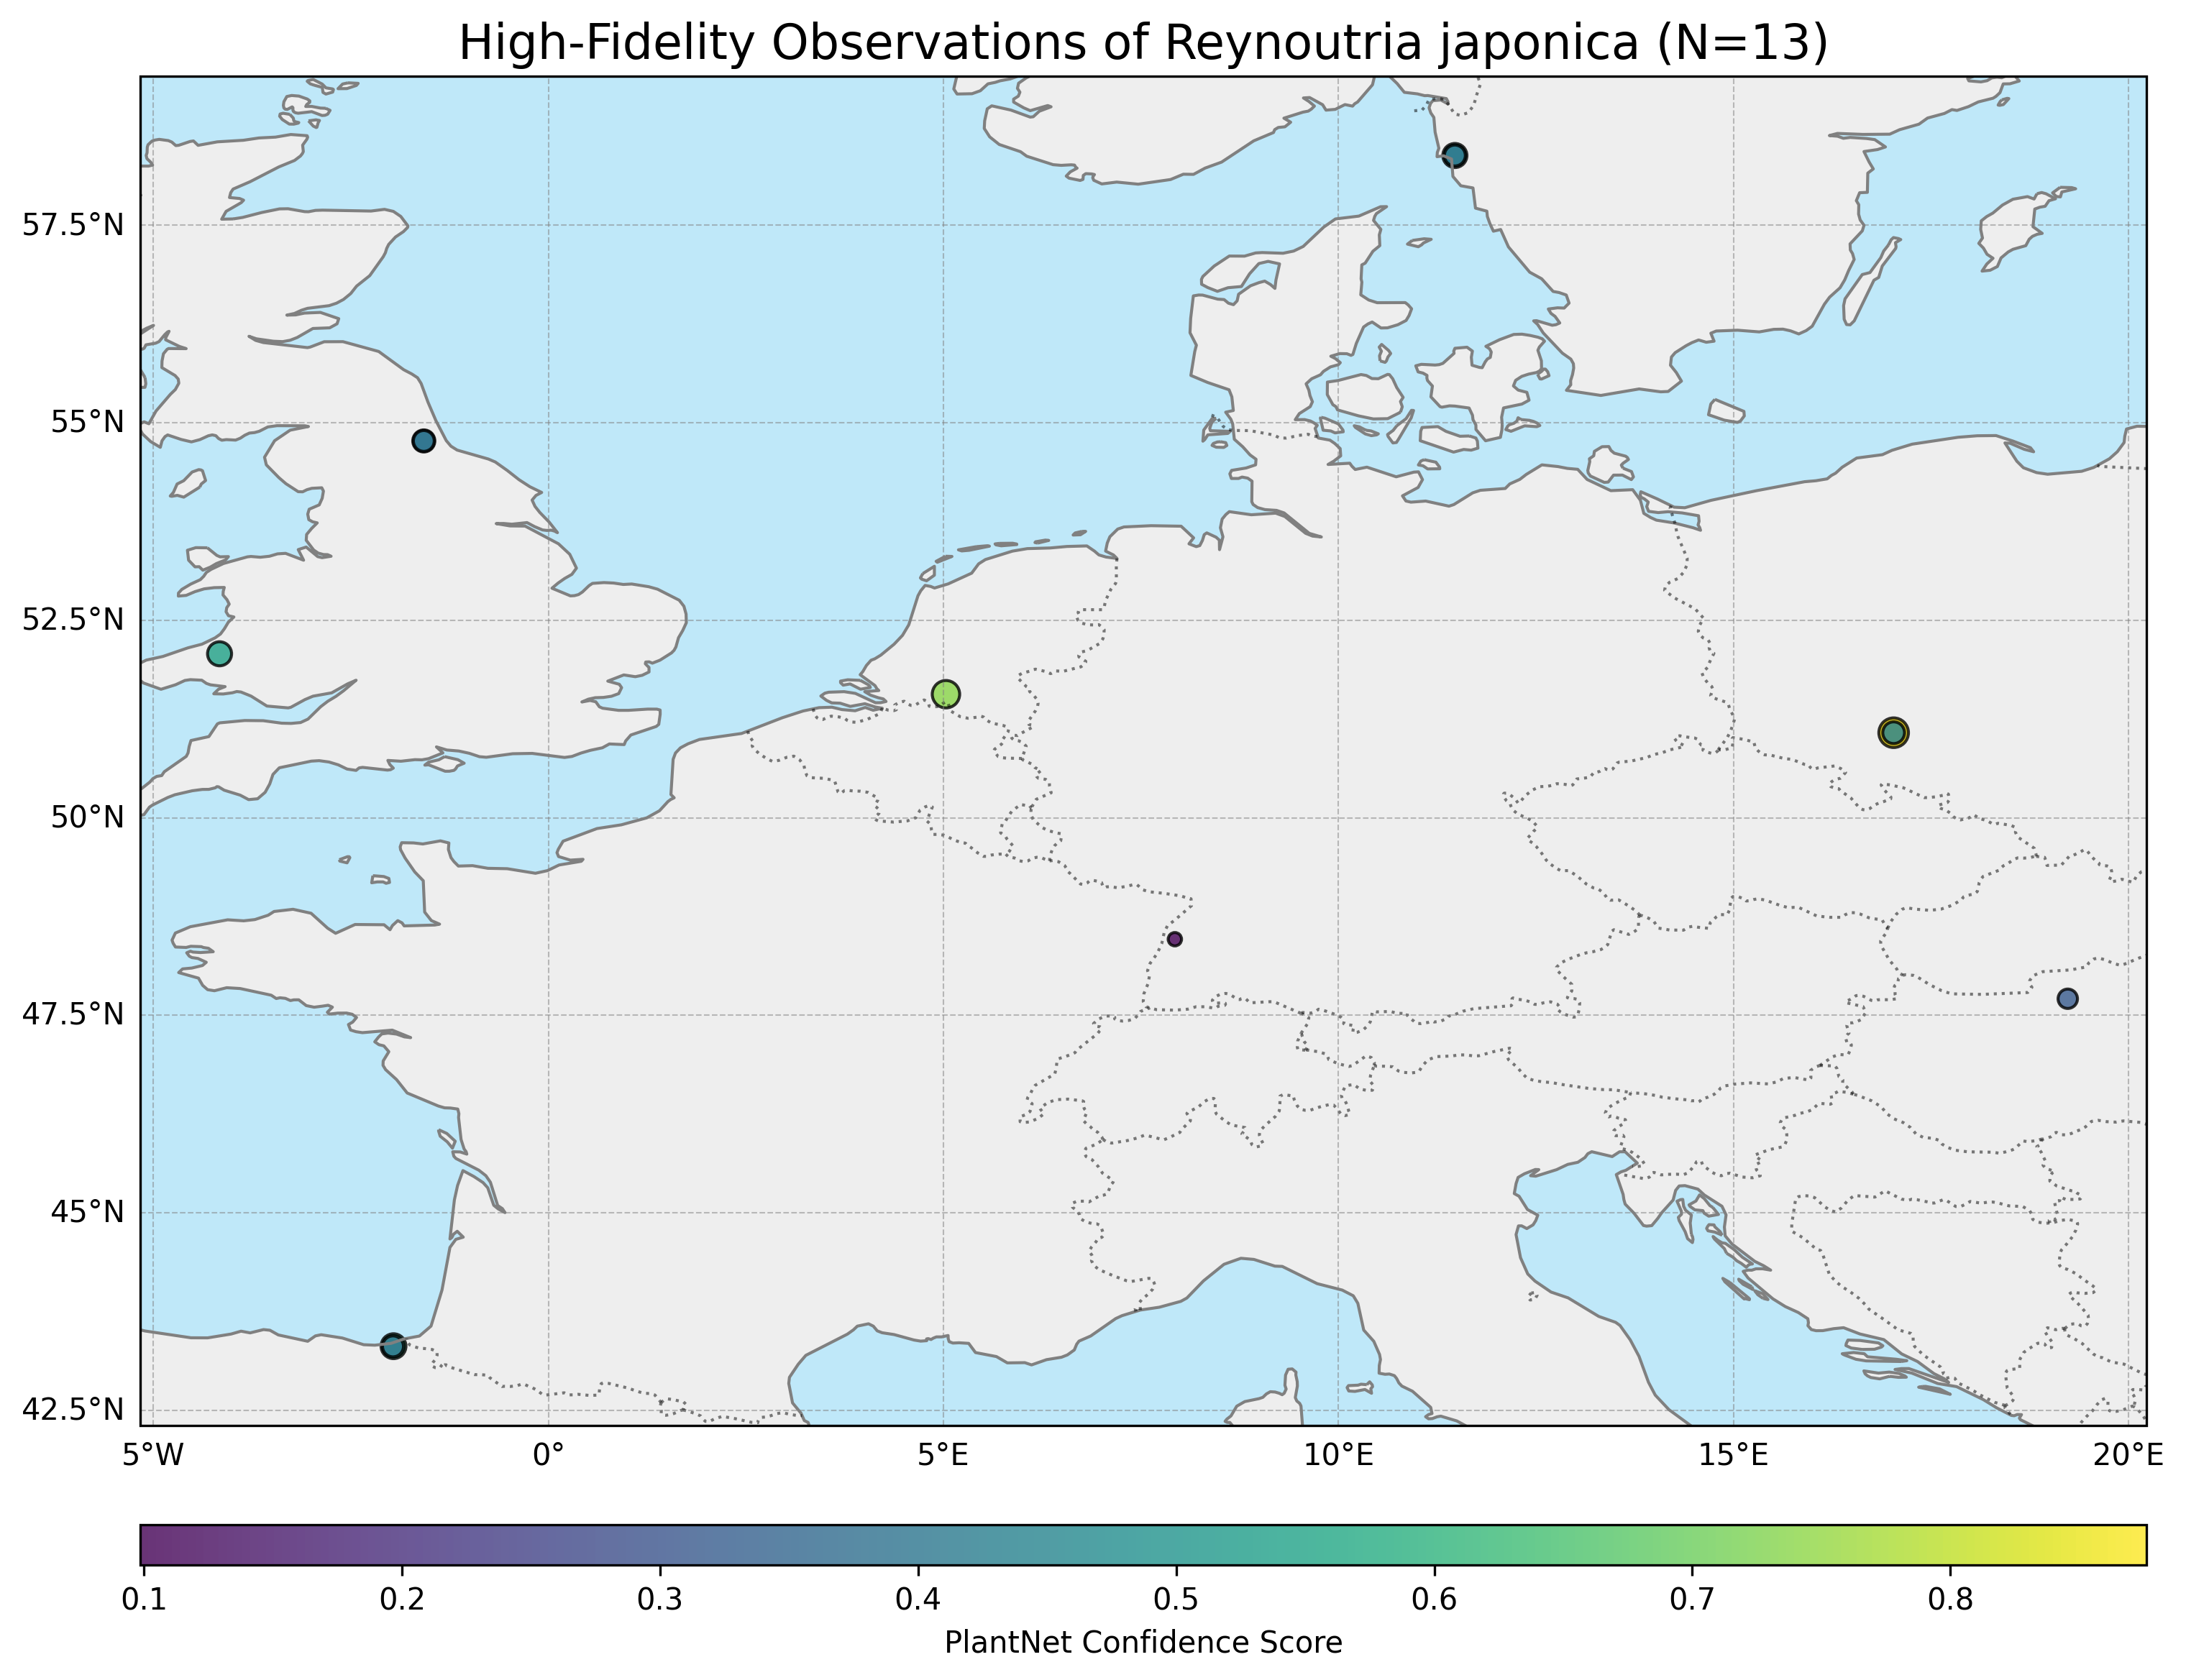

In [10]:
# Assuming you run this successfully first:
# summary, high_fidelity_path, plotting_data_path = run_full_pipeline(...)

# 1. Import the function (assuming the import path is correct)
from flickr_to_plantnet.generate_observation_map import generate_observation_map

import pandas as pd
import os

# A safer approach is to read the file path from the base directory used:
data_file_path = "full_API_validated_plants.csv"

# 2. Call the mapping function with the correct data file path
map_file_path = generate_observation_map(
    data_file_path=data_file_path,  # <--- Change this variable/path
    output_filename="Reynoutria_japonica_EU_Map.png",
    auto_zoom=True
)

print(f"\nMap generation complete. View the file: {map_file_path}")

# Optional: Display the map in the notebook
from IPython.display import Image
Image(map_file_path)